In [59]:
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line


from Bio import Entrez
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

# Dataset Creation
### Task 1: Write a Python program to download at most 10,000 abstracts (in either XML format or just the plain text abstracts) using Entrez utilities belonging to each of the four classes given at the top of the page.

The dataset will be created using the Entrez utility and following search terms. 

- a) Abstracts containing Drug adverse events
    - PubMed Query: "Drug-Related Side Effects and Adverse Reactions"[Mesh]
- b) Abstracts containing Congenital anomalies
    - PubMed Query: "Congenital Abnormalities"[Mesh]
- c) Abstracts containing both (a) and (b)
    - Cases where PMID from A and B overlap
- d) Others
    - PubMed Query: NULL


In [2]:
# Define query methods
def search(query, sample_size):
        Entrez.email = 'cjc2238@tc.columbia.edu'
        handle = Entrez.esearch(db='pubmed',
                                sort='relevance',
                                retmax=str(sample_size),
                                retmode='xml',
                                term=query)
        results = Entrez.read(handle)
        return results
    
def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'cjc2238@tc.columbia.edu'
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

In [3]:
queries = ['"Drug-Related Side Effects and Adverse Reactions"[Majr]',
           '"Congenital Abnormalities"[Majr]',
           '("Drug-Related Side Effects and Adverse Reactions"[Mesh] and "Congenital Abnormalities"[Mesh]) OR ("Drug-Related Side Effects and Adverse Reactions"[Majr] and "Congenital Abnormalities"[Majr])',
           'Other' 
          ]

targets = ['DR', 'CA', 'Both', 'Other']

keys = {'Queries':queries,'Target':targets}
keys = pd.DataFrame(keys)
# keys

In [4]:
df = []

for index, row in keys.iterrows():
    query = row[0]
    target = row[1]
    results = search(query, 3000)
    pmids = results['IdList']
    records = fetch_details(pmids)
    for pubmed in records['PubmedArticle']:
        article = pubmed['MedlineCitation']['Article']
        if 'Abstract' in article: 
            pmid = int(str(pubmed['MedlineCitation']['PMID']))
            abstract = abstract = article['Abstract']['AbstractText'][0]
            mesh = query
            # meshHeadings = pubmed_article['MedlineCitation']['MeshHeadingList']
            df.append({'PMID': pmid, 'Abstract': abstract, 'MESH': mesh, 'Target': target})
        else:
            pass

df = pd.DataFrame(df) 
df = df.drop_duplicates('PMID') # Drop duplicates, removing dupes from DR and CA from Both category

# Exploratory Data Analysis
### Counts and Distribtuions 

In [5]:
df.head(5)

PMID                                           Abstract  \
0  31774327  <b>Introduction</b>: There is a growing list o...   
1  31756458  With the spread of hexavalent chromium [Cr(VI)...   
2  31752003  Non-steroidal anti-inflammatory drugs (NSAIDs)...   
3  31746730  In regard to the current scientific discussion...   
4  31739696  <b>Introduction</b>: The 18<sup>th</sup> Annua...   

                                                MESH Target  
0  "Drug-Related Side Effects and Adverse Reactio...     DR  
1  "Drug-Related Side Effects and Adverse Reactio...     DR  
2  "Drug-Related Side Effects and Adverse Reactio...     DR  
3  "Drug-Related Side Effects and Adverse Reactio...     DR  
4  "Drug-Related Side Effects and Adverse Reactio...     DR

In [6]:
df = df.drop_duplicates('PMID', keep='last')

In [7]:
df.count()

PMID        8699
Abstract    8699
MESH        8699
Target      8699
dtype: int64

In [8]:
df.groupby('Target').count()

PMID  Abstract  MESH
Target                      
Both     687       687   687
CA      2532      2532  2532
DR      2492      2492  2492
Other   2988      2988  2988

In [9]:
alt.data_transformers.disable_max_rows()

bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("Target"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'MESH'],
    color='MESH'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)

alt.LayerChart(...)

In [10]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('Target').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Target'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='Target'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

Initial analysis suggests the "Both" class to be undersampled compared to the rest of the dataset. This could impact model performance, suggest fixing the sample in future iterations by working with PubMed/MESH domain expert. 

###  Abstract length by category
Definition of abstract length field. Although there are special characters in the text (\r, \n), it will be useful as an approximation

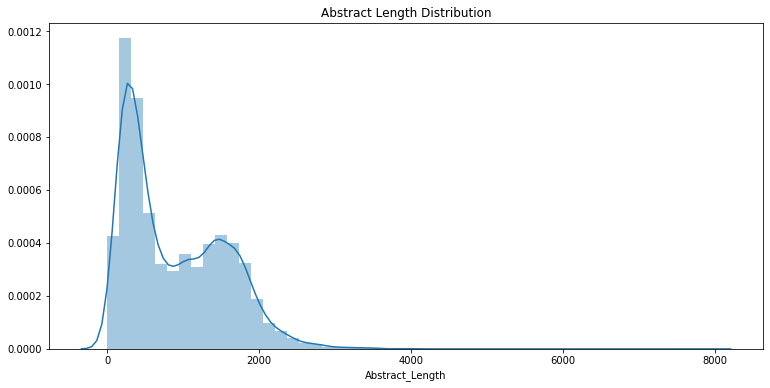

In [11]:

df['Abstract_Length'] = df['Abstract'].str.len()

plt.figure(figsize=(12.8,6))
sns.distplot(df['Abstract_Length']).set_title('Abstract Length Distribution');

In [12]:
df['Abstract_Length'].describe()

count    8699.000000
mean      885.551098
std       659.013912
min         0.000000
25%       312.500000
50%       685.000000
75%      1423.500000
max      7870.000000
Name: Abstract_Length, dtype: float64

Let's remove from the 95% percentile onwards to better appreciate the histogram:

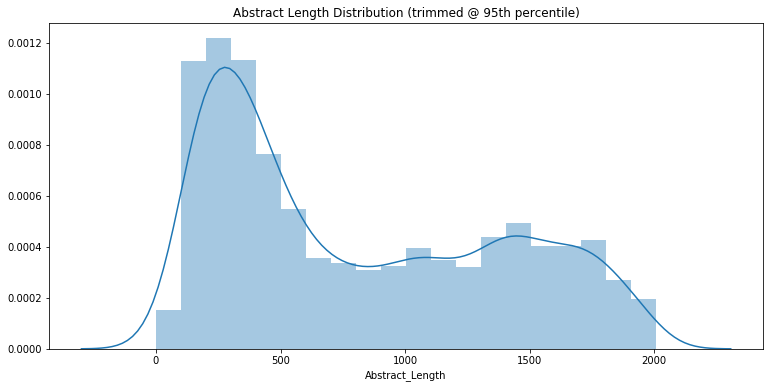

In [13]:
quantile_95 = df['Abstract_Length'].quantile(0.95)
df_95 = df[df['Abstract_Length'] < quantile_95]

plt.figure(figsize=(12.8,6))
sns.distplot(df_95['Abstract_Length']).set_title('Abstract Length Distribution (trimmed @ 95th percentile)');

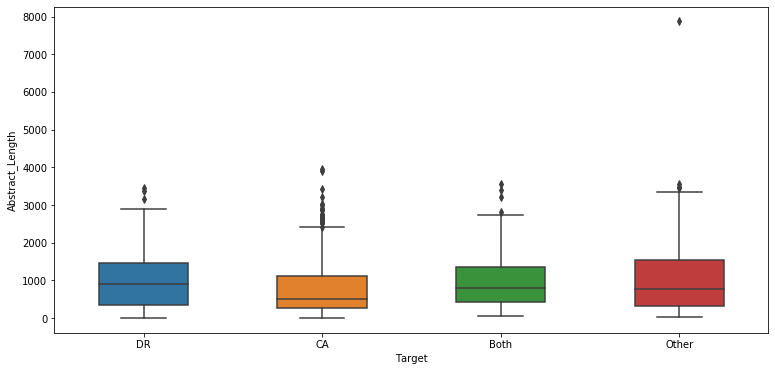

In [14]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Target', y='Abstract_Length', width=.5);

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, I will normalize the features just to avoid this.

At this point, we cannot do further Exploratory Data Analysis. I'll begin the Feature Engineering section.

# Feature Engineering

### Task 2: Write a classifier using any AI/ML technique to classify a given novel set of abstracts into the four classes given above. Perform n-fold cross validation and provide performance metrics for the classification.

Before I can build out any features, I need to clean and prepare the text data by removing special characters, etc. 

In [15]:
# \r and \n
df['Abstract_Parsed'] = df['Abstract'].str.replace("\r", " ") 
df['Abstract_Parsed'] = df['Abstract_Parsed'].str.replace("\n", " ")
df['Abstract_Parsed'] = df['Abstract_Parsed'].str.replace("    ", " ") # quoted text
df['Abstract_Parsed'] = df['Abstract_Parsed'].str.replace('"', '') # quoted text

# Lowercasing the text
df['Abstract_Parsed'] = df['Abstract_Parsed'].str.lower()

# Remove punctuation
punctuation_signs = list("?:!.,;")
df['Abstract_Parsed'] = df['Abstract_Parsed']

for punct_sign in punctuation_signs:
    df['Abstract_Parsed'] = df['Abstract_Parsed'].str.replace(punct_sign, '')
    
# Remove possessive pronouns
df['Abstract_Parsed'] = df['Abstract_Parsed'].str.replace("'s", "")

Since stemming can produce output words that don't exist, I'll only use a lemmatization process at this moment. Lemmatization takes into consideration the morphological analysis of the words and returns words that do exist, so it will be more useful for us.

In [16]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')

# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chad@ibm.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chad@ibm.com/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chad@ibm.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In order to lemmatize, I have to iterate through every word.

In [17]:
from nltk.stem import WordNetLemmatizer 

df = df.reset_index()

lemmatizer = WordNetLemmatizer() 


nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    # Save the text and its words into an object
    text = df.loc[row]['Abstract_Parsed']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(lemmatizer.lemmatize(word, pos="v"))

    # Join the list
    lemmatized_text = " ".join(lemmatized_list)

    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)
    
df['Abstract_Parsed'] = lemmatized_text_list

In [18]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

To remove the stop words, I'll handle a regular expression only detecting whole words.

In [19]:
df['Abstract_Parsed'] = df['Abstract_Parsed']

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['Abstract_Parsed'] = df['Abstract_Parsed'].str.replace(regex_stopword, '')

In [20]:
df.head(5)

index      PMID                                           Abstract  \
0      0  31774327  <b>Introduction</b>: There is a growing list o...   
1      1  31756458  With the spread of hexavalent chromium [Cr(VI)...   
2      2  31752003  Non-steroidal anti-inflammatory drugs (NSAIDs)...   
3      3  31746730  In regard to the current scientific discussion...   
4      4  31739696  <b>Introduction</b>: The 18<sup>th</sup> Annua...   

                                                MESH Target  id  \
0  "Drug-Related Side Effects and Adverse Reactio...     DR   1   
1  "Drug-Related Side Effects and Adverse Reactio...     DR   1   
2  "Drug-Related Side Effects and Adverse Reactio...     DR   1   
3  "Drug-Related Side Effects and Adverse Reactio...     DR   1   
4  "Drug-Related Side Effects and Adverse Reactio...     DR   1   

   Abstract_Length                                    Abstract_Parsed  
0              907  <b>introduction</b>    grow list  drug implica...  
1             1471    spread  hexavalent chromium [cr(vi)] contami...  
2              290  non-steroidal anti-inflammatory drug (nsaids) ...  
3              168   regard   current scientific discussion  analy...  
4              474  <b>introduction</b>  18<sup>th</sup> annual me...

In [21]:
# Drop unwatned columns
list_columns = ["Abstract_Parsed", "Target"]
df = df[list_columns]

# Create a dictionary with the label codification:

abstract_codes = {
    'DR': 0,
    'CA': 1,
    'Both': 2,
    'Other': 3
}

# Category mapping
df['Abstract_Code'] = df['Target']

df = df.replace({'Abstract_Code':abstract_codes})

df.head()

Abstract_Parsed Target  Abstract_Code
0  <b>introduction</b>    grow list  drug implica...     DR              0
1    spread  hexavalent chromium [cr(vi)] contami...     DR              0
2  non-steroidal anti-inflammatory drug (nsaids) ...     DR              0
3   regard   current scientific discussion  analy...     DR              0
4  <b>introduction</b>  18<sup>th</sup> annual me...     DR              0

# Train/Test Split

I'll set apart a test set to prove the quality of our models. I'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Abstract_Parsed'], 
                                                    df['Abstract_Code'], 
                                                    test_size=0.2, 
                                                    random_state=8)


I have various options:

- Count Vectors as features
- TF-IDF Vectors as features
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

**I'll use TF-IDF Vectors as features.**

I have to define the different parameters:

- ngram_range: We want to consider both unigrams and bigrams.
- max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
- min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
- max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [23]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

I have chosen these values as a first approximation. Since the models for this challenge are not expected to be thigh performing I'll stick to these values. But it has to be mentioned that different combinations could be tried in order to improve even more the accuracy of the models.

In [24]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(6959, 300)
(1740, 300)


Please note that I have fitted and then transformed the training set, but we have **only transformed the test set**.

I can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category:

In [25]:
for Product, Target in sorted(abstract_codes.items()):
    features_chi2 = chi2(features_train, labels_train == Target)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' Abstract:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'Both' Abstract:
  . Most correlated unigrams:
. cardiac
. drug
. interval
. pregnancy
. qt
  . Most correlated bigrams:
. liver injury
. drug induced

# 'CA' Abstract:
  . Most correlated unigrams:
. artery
. drug
. cleave
. surgical
. congenital
  . Most correlated bigrams:
. liver injury
. year old

# 'DR' Abstract:
  . Most correlated unigrams:
. drug
. adverse
. reactions
. induced
. liver
  . Most correlated bigrams:
. mg kg
. liver injury

# 'Other' Abstract:
  . Most correlated unigrams:
. induced
. participants
. compare
. race
. self
  . Most correlated bigrams:
. drug induced
. liver injury



As we can see, the unigrams correspond well to their category. However, bigrams do not. If we get the bigrams in our features:

In [26]:
bigrams

['sub sub',
 'sup sup',
 'risk factor',
 '95 ci',
 'mg kg',
 'year old',
 'drug induced',
 'liver injury']

We can see there are only six. This means the unigrams have more correlation with the category than the bigrams, and since we're restricting the number of features to the most representative 300, only a few bigrams are being considered.

# Model Building

Due to time constraints, three models will be built to test performance, a logistic regression, Random Forest, and KNN. Future iterations should explore additional methods such as Gradient Boosting, Naive Bayes, and SVM.

## Multinomial Logistic Regression

In [27]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
print(lr_0.get_params())

Parameters currently in use:

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 8, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


#### Cross-Validation for Hyperparameter tuning


In [28]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
print(lr_0.get_params())

Parameters currently in use:

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 8, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}



We'll tune the following ones:

- C = Inverse of regularization strength. Smaller values specify stronger regularization.
- multi_class = We'll choose multinomial because this is a multi-class problem. solver = Algorithm to use in the optimization problem. For multiclass problems, only newton-cg, sag, saga and lbfgs handle -multinomial loss.
- class_weight: Weights associated with classes.
- penalty: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.

#### Randomized Search Cross Validation
We first need to define the grid:

In [29]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

print(random_grid)

{'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0], 'multi_class': ['multinomial'], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'class_weight': ['balanced', None], 'penalty': ['l2']}


In [30]:
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sa

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=8,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanc

We can see the best hyperparameters resulting from the Random Search:

In [31]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 0.7000000000000001}

The mean accuracy of a model with these hyperparameters is:
0.7728124860596868


#### Grid Search Cross Validation

In [32]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['saga']
class_weight = [None]
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=8, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=...
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0]

The best hyperparameters turn out to be:

In [33]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.9111111111111111, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}

The mean accuracy of a model with these hyperparameters is:
0.7715861268320999


In [34]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=0.9111111111111111, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=8, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False)


We now know the best logistic regression model. Let's fit it and see how it performs:

#### Model fit and performance

In [35]:
best_lrc.fit(features_train, labels_train) # fit the model to our training data
lrc_pred = best_lrc.predict(features_test) # get the predictions


For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

##### Training accuracy

In [36]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.8047133208794367


##### Test accuracy

In [37]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.7741379310344828


In [38]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       511
           1       0.78      0.80      0.79       509
           2       0.83      0.44      0.58       144
           3       0.73      0.81      0.77       576

    accuracy                           0.77      1740
   macro avg       0.79      0.71      0.74      1740
weighted avg       0.78      0.77      0.77      1740



#### Confusion Matrix

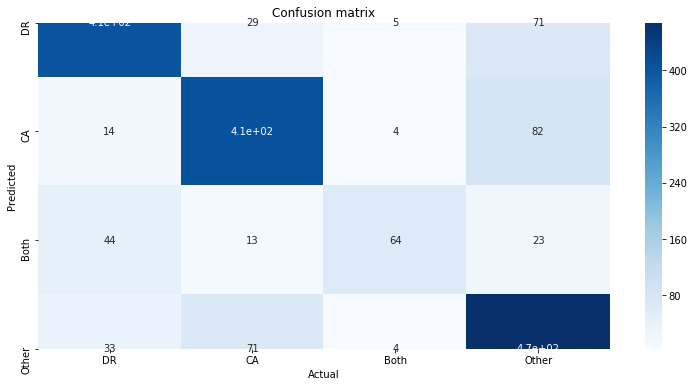

In [39]:
aux_df = df[['Target', 'Abstract_Code']].drop_duplicates().sort_values('Abstract_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Target'].values, 
            yticklabels=aux_df['Target'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

We'll create a dataset with a model summary to compare models:

In [40]:

d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])

In [41]:
df_models_lrc

Model  Training Set Accuracy  Test Set Accuracy
0  Logistic Regression               0.804713           0.774138

## Random Forest

In [42]:
# tune for hyper parameters 
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
print(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 8, 'verbose': 0, 'warm_start': False}


We'll tune the following ones:

- n_estimators = number of trees in the forest.
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)
- min_samples_leaf = min number of data points allowed in a leaf node

Boosting-related hyperparameters:

- learning_rate= learning rate shrinks the contribution of each tree by learning_rate.
- subsample= the fraction of samples to be used for fitting the individual base learners.

#### Randomized Search Cross Validation
We first need to define the grid. 

In [43]:

# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 40, 60, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Perform random search

In [44]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 25.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               


We can see the best hyperparameters resulting from the Random Search:

In [45]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.7758305948362602


After that, we can do a more exhaustive search centered in those values:
#### Grid Search Cross Validation

In [46]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [300]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  7.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sampl...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  


The best hyperparameters turn out to be:

In [47]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

The mean accuracy of a model with these hyperparameters is:
0.7800029023363807


In [48]:
best_rfc = grid_search.best_estimator_
best_rfc


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

#### Model fit and performance

In [49]:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

##### Training Accuracy

In [50]:
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9877856013795085


#### Test Accuracy

In [51]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.7798850574712644


#### Classification Report

In [52]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       511
           1       0.80      0.80      0.80       509
           2       0.89      0.40      0.55       144
           3       0.73      0.84      0.78       576

    accuracy                           0.78      1740
   macro avg       0.81      0.71      0.73      1740
weighted avg       0.79      0.78      0.77      1740



#### Confusion Matrix

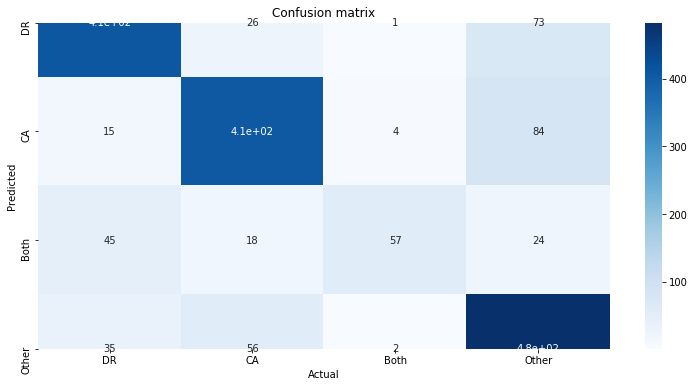

In [53]:
aux_df = df[['Target', 'Abstract_Code']].drop_duplicates().sort_values('Abstract_Code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Target'].values, 
            yticklabels=aux_df['Target'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Store performance in df for later comparison

In [54]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

df_models_rfc

Model  Training Set Accuracy  Test Set Accuracy
0  Random Forest               0.987786           0.779885

# K Nearest Neighbors

### Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [61]:
knnc_0 =KNeighborsClassifier()

print('Parameters currently in use:\n')
print(knnc_0.get_params())

Parameters currently in use:

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


We'll tune the following ones:

- K: Number of neighbors to use by default for queries.

In this case, since there is only one hyperparameter, we'll perform an exhaustive search directly:

#### Grid Search Cross Validation
We first need to define the grid:

In [ ]:
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 500, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best parameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

Since the grid had a space of 5 between each element, we'll now cover all the possible n_neighbors near to 6:

In [ ]:

n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train, labels_train)

The best parameters turn out to be:

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

In [ ]:
best_knnc = grid_search.best_estimator_
best_knnc

### Model fit and performance

In [ ]:
best_knnc.fit(features_train, labels_train)
knn_pred = best_knnc.predict(features_test)

#### Training Accuracy 

In [ ]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_knnc.predict(features_train)))

#### Testing Accuracy

In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, knn_pred))

#### Classification Report

In [ ]:
# Classification report
print("Classification report")
print(classification_report(labels_test,knn_pred))

#### Confusion Matrix

In [ ]:
aux_df = df[['Target', 'Abstract_Code']].drop_duplicates().sort_values('Abstract_Code')
conf_matrix = confusion_matrix(labels_test, knn_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Target'].values, 
            yticklabels=aux_df['Target'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Store model performance in data frame. 

In [ ]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train, best_knn.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, knn_pred)
}

df_models_knn = pd.DataFrame(d, index=[0])

df_models_knn

Lets combine all the model performances into one file.

# Summary

In [ ]:
df_summary = pd.DataFrame()

df_summary = df_summary.append(df_models_lrc)
df_summary = df_summary.append(df_models_rfc)
df_summary = df_summary.append(df_models_knn)
df_summary = df_summary.reset_index().drop('index', axis=1)

df_summary

Overall model performance is suboptimal. This is partly due to the difficulties encountered during the data creation stage of the analysis. Working with a PubMed/MESH content expert would help mitigate these issueswhich would hopefully improve model performance. In additon to working with domain experts, future iterations of model design should explore the following alternative methods of feature extraction (outlined above) and the inclusion of ommited algorithms such as Gradient Boosting.



In [ ]:
# FIXME DRY code, convert o class structures, dockerize, and depoy. 